In [62]:
!pip install category-encoders
import pandas as pd
import category_encoders
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error, r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBRegressor
import numpy as np
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


Отфильтруем по региону 2661 – Санкт-Петербург и область.

In [2]:
data = pd.read_csv("/content/drive/MyDrive/all_v2.csv")
data = data[data["region"]==2661].reset_index(drop=True)
data

price        date      time    geo_lat    geo_lon  region  \
0        6050000  2018-02-19  20:00:21  59.805808  30.376141    2661   
1        3600000  2018-03-04  20:52:38  59.875526  30.395457    2661   
2        3200000  2018-04-10  16:10:12  59.827465  30.201827    2661   
3        6500000  2018-04-23  11:47:58  59.988334  29.786928    2661   
4        6300000  2018-04-28  17:47:24  59.911622  30.284556    2661   
...          ...         ...       ...        ...        ...     ...   
181234   3284000  2019-11-04  14:02:33  59.986323  30.415381    2661   
181235   9950000  2019-11-04  14:06:32  59.916664  30.326478    2661   
181236   3600000  2019-11-04  14:06:33  59.835632  30.511000    2661   
181237  18400000  2019-11-04  14:06:44  60.017715  30.289331    2661   
181238  14890000  2019-11-04  14:06:44  59.959393  30.285702    2661   

        building_type  level  levels  rooms  area  kitchen_area  object_type  
0                   1      8      10      3  82.6          10.8          1.0  
1                   1      2       5      1  31.1           6.0          1.0  
2                   1      7       9      1  31.0           7.0          1.0  
3                   3      3       3      3  89.0          10.0          1.0  
4                   3      5       5      2  99.9          14.5          1.0  
...               ...    ...     ...    ...   ...           ...          ...  
181234              1      3       5      1  31.2           6.3          1.0  
181235              3      1       5      3  97.0          11.0          1.0  
181236              3      1      15      1  27.0           8.0          1.0  
181237              3      4       4      3  96.0          15.0          1.0  
181238              3      3       8      2   NaN           NaN          NaN  

[181239 rows x 13 columns]

Оставим только типовые объекты: S общ - 20-200 кв. м., S кухни 6-30 кв. м., Цена 1,5-50 млн.
Число комнат «-1» и «-2» заменим на 0.

In [8]:
mask = (data['price'] >= 150000) & (data['price'] <= 50000000) & (data['area'] >= 20) & (data['area'] <= 200) & (data['kitchen_area'] >= 6) & (data['area'] <= 30)
filtered_data = data[mask].reset_index(drop=True)
filtered_data['rooms'] = filtered_data['rooms'].replace({-1: 0, -2: 0})


Добавим признаки: Этаж квартиры/Этажность, Первый, Последний этаж, ratio = (S кухни/S
общая). Если число комнат 0, то ratio = S общая.

In [9]:
filtered_data["level/levels"] = filtered_data["level"]/filtered_data["levels"]
filtered_data["first_lavel"] = filtered_data["level"]==1
filtered_data["first_lavel"] = filtered_data["first_lavel"] .replace({True: 1, False: 0})
filtered_data["end_lavel"] = filtered_data["level"]==filtered_data["levels"]
filtered_data["end_lavel"] = filtered_data["end_lavel"] .replace({True: 1, False: 0})
def calculate_ratio(col1, col2, col3):
  if col3 == 0:
    return col2
  else:
    return col1 / col2
filtered_data["ratio"] = filtered_data["kitchen_area"]/filtered_data["area"]
filtered_data.loc[filtered_data["rooms"] == 0, 'ratio'] = filtered_data["area"]


Добавим признак Давность объявления. В качестве даты отсчета используем дату


In [10]:
filtered_data['date'] = pd.to_datetime(filtered_data['date'])
last_date = filtered_data['date'].max()
filtered_data['Давность'] = last_date - filtered_data['date']
filtered_data['Давность'] = filtered_data['Давность'].dt.days
filtered_data

price       date      time    geo_lat    geo_lon  region  \
0     2250000 2018-09-08  10:13:54  59.883033  29.839192    2661   
1     2550000 2018-09-09  02:02:26  59.904302  30.472130    2661   
2     3200000 2018-09-09  14:25:01  59.915995  30.470351    2661   
3     3250000 2018-09-09  14:26:36  59.983635  30.396874    2661   
4     2340819 2018-09-09  14:46:42  59.892809  30.449312    2661   
...       ...        ...       ...        ...        ...     ...   
3477  2950000 2019-11-03  21:23:30  59.902876  30.464171    2661   
3478  4250000 2019-11-03  23:54:55  60.011803  30.381513    2661   
3479  3490000 2019-11-04  07:49:22  59.865825  30.509671    2661   
3480  2160000 2019-11-04  11:38:04  59.990746  30.432532    2661   
3481  3600000 2019-11-04  14:06:33  59.835632  30.511000    2661   

      building_type  level  levels  rooms  area  kitchen_area  object_type  \
0                 3      4       5      0  29.0          6.00          1.0   
1                 3      4      18      0  29.0          6.00          1.0   
2                 1      4       9      1  29.0          7.00          1.0   
3                 2      4      24      0  28.0          6.00         11.0   
4                 2      9      15      0  25.7         17.60         11.0   
...             ...    ...     ...    ...   ...           ...          ...   
3477              1      1       9      1  28.7          6.80          1.0   
3478              2     15      18      0  28.3          6.00          1.0   
3479              2     20      23      1  29.7          8.19          1.0   
3480              1     10      25      0  21.6          6.10         11.0   
3481              3      1      15      1  27.0          8.00          1.0   

      level/levels  first_lavel  end_lavel      ratio  Давность  
0         0.800000            0          0  29.000000       422  
1         0.222222            0          0  29.000000       421  
2         0.444444            0          0   0.241379       421  
3         0.166667            0          0  28.000000       421  
4         0.600000            0          0  25.700000       421  
...            ...          ...        ...        ...       ...  
3477      0.111111            1          0   0.236934         1  
3478      0.833333            0          0  28.300000         1  
3479      0.869565            0          0   0.275758         0  
3480      0.400000            0          0  21.600000         0  
3481      0.066667            1          0   0.296296         0  

[3482 rows x 18 columns]

Построим корреляционную матрицу этих признаков

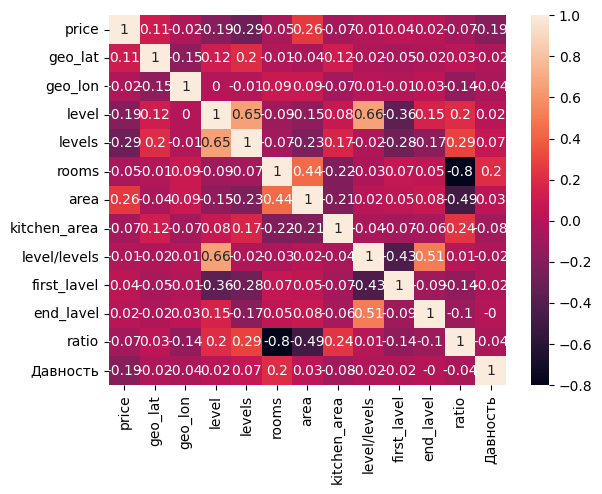

In [16]:
corr_data = filtered_data[["price","geo_lat", "geo_lon", "level", 'levels', "rooms", "area", "kitchen_area", "level/levels", "first_lavel", "end_lavel", "ratio", "Давность"]]
correlation_matrix = corr_data.corr().round(2)
plt.figure(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Разбьем на обучающее и тестовое множества в пропорции 80/20, random_seed = 42.

In [17]:
X = corr_data.drop("price", axis=1)
y = corr_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Стандартизируем числовые признаки и построим модель линейной регрессии с L2-
регуляризацией

In [19]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled_train, y_train)

y_pred_train = ridge.predict(X_scaled_train)
y_pred_test = ridge.predict(X_scaled_test)

rmsle_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Обучающая выборка:")
print("RMSLE:", rmsle_train)
print("R2:", r2_train)
print("MAE:", mae_train)

rmsle_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Тестовая выборка:")
print("RMSLE:", rmsle_test)
print("R2:", r2_test)
print("MAE:", mae_test)


Обучающая выборка:
RMSLE: 691149.1443476744
R2: 0.20946104781794594
MAE: 519169.6771916857
Тестовая выборка:
RMSLE: 713216.2911120735
R2: 0.22453179597413908
MAE: 529746.436957942


Построим модель XGBoost

In [20]:
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 Рассчитаем регрессионные метрики RMSLE, R2, MAE для обучающей и тестовой выборок


In [21]:
y_pred_train = xgboost_model.predict(X_train)
y_pred_test = xgboost_model.predict(X_test)

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Обучающая выборка:")
print("RMSLE:", rmsle_train)
print("R2:", r2_train)
print("MAE:", mae_train)

rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Тестовая выборка:")
print("RMSLE:", rmsle_test)
print("R2:", r2_test)
print("MAE:", mae_test)


Обучающая выборка:
RMSLE: 0.12532039131908324
R2: 0.7790820634401995
MAE: 248995.36418312386
Тестовая выборка:
RMSLE: 0.19432559830213078
R2: 0.5016381346281961
MAE: 364064.5292324247


Значимые признаки

In [25]:
feature_importances = xgboost_model.feature_importances_
print(X_train.columns)
print(feature_importances)

Index(['geo_lat', 'geo_lon', 'level', 'levels', 'rooms', 'area',
       'kitchen_area', 'level/levels', 'first_lavel', 'end_lavel', 'ratio',
       'Давность'],
      dtype='object')
[0.11818685 0.12841281 0.05558202 0.20288661 0.02097023 0.16525501
 0.07197692 0.04619885 0.         0.         0.08181492 0.10871579]


Real Estate Rent in Moscow

In [26]:
data = pd.read_csv("/content/drive/MyDrive/move.csv")
data

Unnamed: 0                         metro  price   way  views  \
0              0                   Planernaia   45000  walk    513   
1              1                        VDNKh   50000  walk    389   
2              2                Alekseevskaia   50000  walk    483   
3              3                     Sviblovo   38000  walk    414   
4              4                     Rimskaia   55999  walk    360   
...          ...                           ...    ...   ...    ...   
1441        1441                    Solntcevo   25000  walk    189   
1442        1442    Ulitca Starokachalovskaia   25000  walk    173   
1443        1443                    Zhulebino   25000  walk    102   
1444        1444   Preobrazhenskaia ploshchad   40000  walk     60   
1445        1445                  Rasskazovka   30000  walk   2728   

                         provider  fee_percent  storey  minutes  storeys  \
0     realtor                               50       7       10       12   
1     realtor                               50      16       10       16   
2     realtor                               50       5        3       12   
3     realtor                               50       3       15        5   
4     realtor                               99       6        7       17   
...                           ...          ...     ...      ...      ...   
1441     realtor                             0       6        5       23   
1442     realtor                             0       5        5       17   
1443     realtor                             0       5        5       12   
1444     realtor                            30       3       17        9   
1445       owner                             0      12       10       17   

      living_area  kitchen_area  total_area  
0              19             8          38  
1              18             8          41  
2              19             5          33  
3              37            37          37  
4              21            10          40  
...           ...           ...         ...  
1441           20            10          36  
1442           20            10          38  
1443           20            10          35  
1444           20             8          35  
1445           22             8          33  

[1446 rows x 13 columns]

Удалим лишние признаки

In [40]:
data = data.drop(["metro"], axis=1)

In [41]:
data

price  fee_percent  storey  minutes  storeys  living_area  total_area  \
0    45000           50       7       10       12           19          38   
1    50000           50      16       10       16           18          41   
2    50000           50       5        3       12           19          33   
3    38000           50       3       15        5           37          37   
4    55999           99       6        7       17           21          40   
..     ...          ...     ...      ...      ...          ...         ...   
239  45000           50      22        0       22           13          21   
240  29000           50       3       18        9           37          37   
241  43000           70       1       11        5           16          31   
242  60000           50       5        2       26           37          37   
243  30000            0       2        0        4           37          37   

     provider_agency                   provider_agency                      \
0                                   0                                    0   
1                                   0                                    0   
2                                   0                                    0   
3                                   0                                    0   
4                                   0                                    0   
..                                ...                                  ...   
239                                 0                                    0   
240                                 0                                    0   
241                                 1                                    0   
242                                 0                                    0   
243                                 1                                    0   

     provider_agency                         provider_owner                   \
0                                         0                                0   
1                                         0                                0   
2                                         0                                0   
3                                         0                                0   
4                                         0                                0   
..                                      ...                              ...   
239                                       0                                0   
240                                       0                                0   
241                                       0                                0   
242                                       0                                0   
243                                       0                                0   

     provider_realtor                   provider_realtor                      \
0                                    0                                     1   
1                                    0                                     1   
2                                    0                                     1   
3                                    0                                     1   
4                                    0                                     1   
..                                 ...                                   ...   
239                                  0                                     0   
240                                  0                                     0   
241                                  0                                     0   
242                                  0                                     0   
243                                  0                                     0   

     provider_Застройщик                   way_transport  way_walk  
0                                       0              0         1  
1                                       0              0         1  
2 

Избавимся от выбросов

In [42]:
z = np.abs(stats.zscore(data))
#only keep rows in dataframe with all z-scores less than absolute value of 3
data_clean = data[(z<3).all(axis=1)]

In [43]:
data_clean

price  fee_percent  storey  minutes  storeys  living_area  total_area  \
16   38000            0       7        5       12           19          39   
17   45000            0       6       15        9           19          33   
22   45000            0       5        5       15           25          52   
29   30000            0      12       10       17           22          33   
30   25000            0       3        7        9           18          40   
..     ...          ...     ...      ...      ...          ...         ...   
239  45000           50      22        0       22           13          21   
240  29000           50       3       18        9           37          37   
241  43000           70       1       11        5           16          31   
242  60000           50       5        2       26           37          37   
243  30000            0       2        0        4           37          37   

     provider_agency                   provider_agency                      \
16                                  0                                    0   
17                                  0                                    0   
22                                  0                                    0   
29                                  0                                    0   
30                                  0                                    0   
..                                ...                                  ...   
239                                 0                                    0   
240                                 0                                    0   
241                                 1                                    0   
242                                 0                                    0   
243                                 1                                    0   

     provider_agency                         provider_owner                   \
16                                        0                                1   
17                                        0                                1   
22                                        0                                1   
29                                        0                                1   
30                                        0                                1   
..                                      ...                              ...   
239                                       0                                0   
240                                       0                                0   
241                                       0                                0   
242                                       0                                0   
243                                       0                                0   

     provider_realtor                   provider_realtor                      \
16                                   0                                     0   
17                                   0                                     0   
22                                   0                                     0   
29                                   0                                     0   
30                                   0                                     0   
..                                 ...                                   ...   
239                                  0                                     0   
240                                  0                                     0   
241                                  0                                     0   
242                                  0                                     0   
243                                  0                                     0   

     provider_Застройщик                   way_transport  way_walk  
16                                      0              0         1  
17                                      0              0         1  
22

In [50]:
print(data_clean.columns)

Index(['price', 'fee_percent', 'storey', 'minutes', 'storeys', 'living_area',
       'total_area', 'provider_agency                 ',
       'provider_agency                    ',
       'provider_agency                       ',
       'provider_owner                 ', 'provider_realtor                 ',
       'provider_realtor                    ',
       'provider_Застройщик                 ', 'way_transport', 'way_walk'],
      dtype='object')


In [52]:
new_data = data_clean[['price', 'fee_percent', 'storey', 'minutes', 'storeys', 'living_area',
       'total_area', 'provider_owner                 ', 'way_transport', 'way_walk']].copy()

Построим корреляционную матрицу

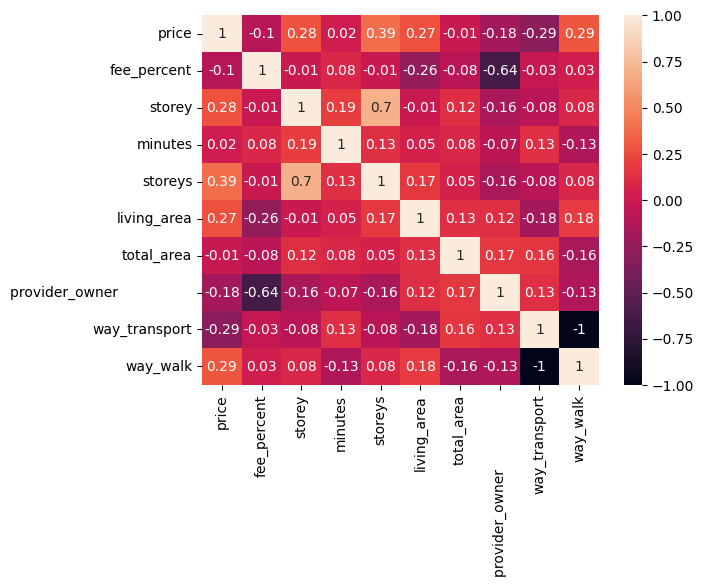

In [53]:
corr_data = new_data
correlation_matrix = corr_data.corr().round(2)
plt.figure(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Произведем разделение выборки

In [56]:
X = new_data.drop("price", axis=1)
y = new_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


XGBoost

In [57]:
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
y_pred_train = xgboost_model.predict(X_train)
y_pred_test = xgboost_model.predict(X_test)

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Обучающая выборка:")
print("RMSLE:", rmsle_train)
print("R2:", r2_train)
print("MAE:", mae_train)

rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Тестовая выборка:")
print("RMSLE:", rmsle_test)
print("R2:", r2_test)
print("MAE:", mae_test)

Обучающая выборка:
RMSLE: 0.0818419961463783
R2: 0.986376161203434
MAE: 2080.5990454445423
Тестовая выборка:
RMSLE: 0.352766757222835
R2: 0.42401693711902133
MAE: 11910.955674913195


RandomForest

In [60]:
RandomForest_model = RandomForestRegressor(n_estimators=100, random_state=42)
RandomForest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [61]:
y_pred_train = RandomForest_model.predict(X_train)
y_pred_test = RandomForest_model.predict(X_test)

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Обучающая выборка:")
print("RMSLE:", rmsle_train)
print("R2:", r2_train)
print("MAE:", mae_train)

rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Тестовая выборка:")
print("RMSLE:", rmsle_test)
print("R2:", r2_test)
print("MAE:", mae_test)


Обучающая выборка:
RMSLE: 0.15587289331635226
R2: 0.9066399996503384
MAE: 5252.078169014085
Тестовая выборка:
RMSLE: 0.3190988139362204
R2: 0.5442837841275794
MAE: 11069.8


ExtraTree

In [64]:
ExtraTrees_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
ExtraTrees_model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [65]:
y_pred_train = ExtraTrees_model.predict(X_train)
y_pred_test = ExtraTrees_model.predict(X_test)

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Обучающая выборка:")
print("RMSLE:", rmsle_train)
print("R2:", r2_train)
print("MAE:", mae_train)

rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Тестовая выборка:")
print("RMSLE:", rmsle_test)
print("R2:", r2_test)
print("MAE:", mae_test)

Обучающая выборка:
RMSLE: 0.00016800225224457405
R2: 0.9999998422009458
MAE: 1.6901408450704225
Тестовая выборка:
RMSLE: 0.34182620125250557
R2: 0.49806866353982915
MAE: 11278.472222222223


ExtraTree является лучшей моделью, найдем значимости

In [66]:
feature_importances = ExtraTrees_model.feature_importances_
res = list(zip(X_train.columns, feature_importances))
print(res)


[('fee_percent', 0.15191032973793506), ('storey', 0.15431542917903518), ('minutes', 0.11827044618659294), ('storeys', 0.25520855308224005), ('living_area', 0.13380575622906507), ('total_area', 0.06620371960521472), ('provider_owner                 ', 0.05329965024408155), ('way_transport', 0.03106233467177695), ('way_walk', 0.03592378106405844)]
